# Azure ML Workspace

## Importing libraries

In [97]:
from azureml.core import Workspace, Environment, Model
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
import json
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Initialise workspace
Initialise a workspace using the values from config.json
If this file is not found, an exception occurs
When an exception is detected, a workspace using the defined details is created

In [98]:
# An authentication error started occurring with the Azure Portal, this seems to fix it
# Issue found at https://github.com/Azure/MachineLearningNotebooks/issues/131
auth = InteractiveLoginAuthentication(tenant_id="57af78f2-c87d-4466-b7bb-6b6cc99ed124")

try:
# Try to load workspace
    wspace = Workspace.from_config(auth=auth)
except Exception as ex:
# Create new workspace if existing is not found
    wspace = Workspace.create(name="classification-workspace",
                              subscription_id="11636c4c-f408-4202-980a-b738e97f4d7f",
                              resource_group="classification-resources",
                              create_resource_group=True,
                              location="uksouth")

# Write workspace config to a local file
    wspace.write_config()

print("Workspace successfully loaded")

Workspace successfully loaded


## Create an environment
Create an environment for the model to run on the Azure servers

In [99]:
# Load conda dependencies required for this environment.
# Register environment for the workspace
env = Environment("env")

conda_dep = CondaDependencies.create(pip_packages=["pandas == 1.1.3",
                                                   "azureml-core",
                                                   "azureml-defaults >= 1.0.45"],
                                     conda_packages=["scikit-learn == 0.23.2"])

env.python.conda_dependencies = conda_dep

env.register(workspace=wspace)

print("Environment Registered")

# Get the environment created from the workspace and create a file to verify it has been defined
my_env = Environment.get(workspace=wspace, name="env")
my_env.save_to_directory("./environ", overwrite=True)

print("Environment Saved")

inference_config = InferenceConfig(entry_script="score.py",
                                   environment=my_env)

Environment Registered
Environment Saved


## Register the models
Register the saved model created by "knn-model-tuning" and "svm-model-tuning" for use on Azure ML

In [100]:
knn_model = Model.register(workspace=wspace,
                       model_name="knn",
                       model_path="models/knn.pkl",
                       model_framework="ScikitLearn",
                       description="Tuned KNN for Genre Classification")

svm_model = Model.register(workspace=wspace,
                       model_name="svm",
                       model_path="models/svm.pkl",
                       model_framework="ScikitLearn",
                       description="Tuned SVM for Genre Classification")

Registering model knn
Registering model svm


## Set up Azure Container Instance
Define ACI Webservice

In [101]:
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

## Deploy the models
Deploy the models onto the defined ACI container using the set environment, inference config and workspace

In [102]:
service = Model.deploy(workspace=wspace,
                       name="music-genre-service",
                       models=[knn_model, svm_model],
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       overwrite=True)

service.wait_for_deployment(show_output=True)
print(service.get_logs())

print(service.scoring_uri)

Running.................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
2021-04-22T12:37:41,234418300+00:00 - iot-server/run 
2021-04-22T12:37:41,235043500+00:00 - gunicorn/run 
2021-04-22T12:37:41,250377100+00:00 - rsyslog/run 
2021-04-22T12:37:41,271216700+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_bc84c8b1e6f800381723c1af65ff7e9c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_bc84c8b1e6f800381723c1af65ff7e9c/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_bc84c8b1e6f800381723c1af65ff7e9c/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_bc84c8b1e6f800381723c1af65ff7e9c/lib/libssl.so.1.0.0: no version information available 

## Test the web service
Test the web service has successfully deployed using test data

         Genre KNN Prediction SVM Prediction
0    Classical      Classical      Classical
1          Pop          Disco            Pop
2        Disco           Jazz        Country
3       Reggae           Jazz          Blues
4        Metal          Metal          Metal
..         ...            ...            ...
295       Jazz        Country         HipHop
296     HipHop          Disco         HipHop
297      Blues           Jazz          Blues
298       Jazz        Country         HipHop
299     Reggae         Reggae         HipHop

[300 rows x 3 columns]
                              KNN       SVM
Classification Accuracy  0.300000  0.343333
AUROC                    0.726619  0.786094
F1                       0.300000  0.343333
         Genre KNN Prediction SVM Prediction
0    Classical      Classical      Classical
1          Pop          Disco            Pop
2        Disco           Jazz        Country
3       Reggae           Jazz          Blues
4        Metal          Metal      

Text(0.5, 1.0, 'SVM Confusion Matrix')

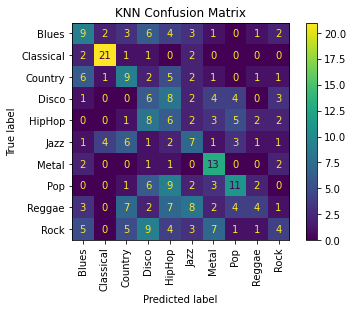

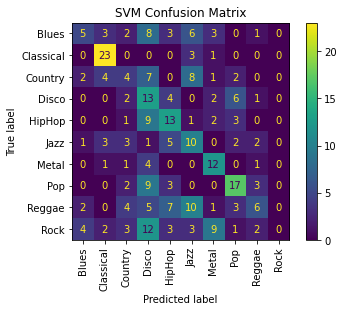

In [103]:
# Reading the test set from file
data_df = pd.read_csv("testing_data.csv")
data_json_str = data_df.to_json(orient="records")

response_pred, response_acc= service.run(json.dumps(data_json_str))

response_pred_df = pd.DataFrame(response_pred)
response_acc_df = pd.DataFrame(response_acc, index=["Classification Accuracy", "AUROC", "F1"])

print(response_pred_df)
print(response_acc_df)


# Reading the test set from file
data_df = pd.read_csv("testing_data.csv")
data_json_str = data_df.to_json(orient="records")

response_pred, response_acc= service.run(json.dumps(data_json_str))

response_pred_df = pd.DataFrame(response_pred)
response_acc_df = pd.DataFrame(response_acc, index=["Classification Accuracy", "AUROC", "F1"])

print(response_pred_df)
print(response_acc_df)

# As plot_confusion_matrix requires the classifier to run, the matrix will be built and plotted separately here
knn_conf = confusion_matrix(y_true=response_pred_df["Genre"], y_pred=response_pred_df["KNN Prediction"])
knn_conf_mat = ConfusionMatrixDisplay(confusion_matrix=knn_conf,
                       display_labels=["Blues", "Classical", "Country", "Disco", "HipHop",
                                       "Jazz", "Metal", "Pop", "Reggae", "Rock"])
knn_conf_mat.plot(xticks_rotation="vertical")
plt.title("KNN Confusion Matrix")


svm_conf = confusion_matrix(y_true=response_pred_df["Genre"], y_pred=response_pred_df["SVM Prediction"])
svm_conf_mat = ConfusionMatrixDisplay(confusion_matrix=svm_conf,
                       display_labels=["Blues", "Classical", "Country", "Disco", "HipHop",
                                       "Jazz", "Metal", "Pop", "Reggae", "Rock"])
svm_conf_mat.plot(xticks_rotation="vertical")
plt.title("SVM Confusion Matrix")

## Delete ACI
Delete the ACI instance to clean up
(This will also delete the endpoint)

In [104]:
# service.delete()